# Example: Single Contract Profit/Loss Analysis
In this example, we will analyze the profit and loss of single long (short) call (put) options contracts.

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Construct option contract models__ for single call and put options by extracting premium data from options chains and specifying strike prices and position direction.
> * __Compute payoff and profit diagrams__ for individual option contracts across a range of underlying asset prices at expiration, accounting for premium costs.
> * __Calculate breakeven points__ for single options contracts using analytical expressions and verify them through profit diagrams.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the data in the `metadata::Dict{String,Any}` and `optionschain::DataFrame` variables.

In [6]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="amd");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the metadata dictionary?

In [8]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

What about the optionschain variable?

In [10]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [12]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64,x); # set the initial share price

What is the current underlying share price?

In [14]:
println("Current underlying share price: $(round(Sₒ,digits=2)) USD/share");

Current underlying share price: 225.78 USD/share


____

## Task 1: Profit/Loss Analysis for Single Call Contracts
In this task, we will analyze the profit and loss of single long (short) call options contracts. 

Let's extract the call option data from the `optionschain::DataFrame` dataset and filter for a specific strike price. We'll then build an instance of [the `MyAmericanCallContractModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) using the [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}).

We'll store the contract model in the `call_contract_model::MyAmericanCallContractModel` variable.

In [17]:
call_contract_model = let
    
    # initialize -
    options_dataset =  optionschain;
    θ = 1; # 1 = long and -1 = short
    K = 230.0; # strike price
    premium = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Mid];

    # build the model -
    call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium, sense = θ, copy = 1
    ));

    # return
    call_contract_model;
end

MyAmericanCallContractModel(230.0, 1, nothing, nothing, 21.58, nothing, 1)

We pay (or collect) this premium:

In [19]:
println("Premium paid for call option: $(round(call_contract_model.premium,digits=2)) USD/share");

Premium paid for call option: 21.58 USD/share


Recall the current underlying share price:

In [21]:
println("Current underlying share price: $(round(Sₒ,digits=2)) USD/share");

Current underlying share price: 225.78 USD/share


### Visualize Profit and Loss
Next, let's use [the `payoff(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff) to compute the payoff at expiration for a range of underlying share prices. We'll also use [the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) to compute the profit at expiration, considering the premium paid or received for the option.

In [23]:
payoff_call, profit_call = let
    
    # initialize -
    δ = 0.50; # share price increment
    Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64,x); # set the initial share price (this has no importance now because we have the options chain data)
    contract_model = call_contract_model;
    S_expiration = range((1-δ)*Sₒ, stop=Sₒ*(1+δ), step=0.1) |> collect; # share prices at expiration

    # compute payoff and profit -
    payoff_call = payoff([contract_model], S_expiration);
    profit_call = profit([contract_model], S_expiration);

    # return
    (payoff_call, profit_call);
end;

Let's visualize the profit/loss profile of the call option at different possible underlying share prices at expiration using [the `plot(...)` function from the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl).

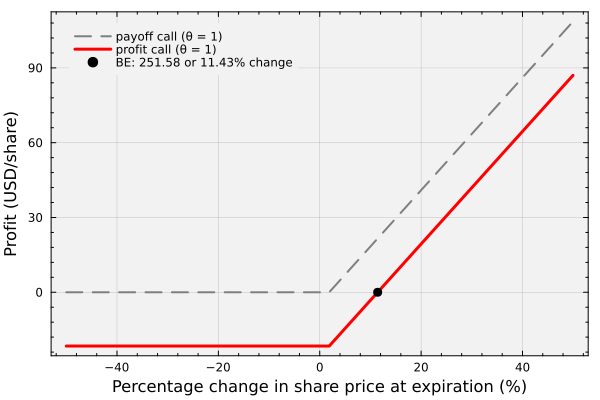

In [25]:
let

    # initialize -
    θ = call_contract_model.sense;
    K = call_contract_model.K;
    premium = call_contract_model.premium;
    number_of_steps = length(payoff_call[:,1]);

    # BEL = zeros(number_of_steps);
    # plot(profit_call[:,1],BEL,lw=3, c=:green, label="Break-even line")
    S = ((payoff_call[:,1] .- Sₒ)./Sₒ) * 100;
    

    plot(S, payoff_call[:,2],
        lw = 2, 
        c = :gray50,
        ls = :dash,
        label = "payoff call (θ = $(θ))",
        minorticks = 5,
    );

    plot!(S, profit_call[:,2],
        lw = 3, 
        c = :red,
        label = "profit call (θ = $(θ))", 
    );    

    # VLINE = zeros(number_of_steps, 2)
    # VLINE[:,1] .= K*ones(number_of_steps)
    # VLINE[:,2] .= range(minimum(-1*profit_call[:,end]), stop = maximum(profit_call[:,end]), length = number_of_steps) |> collect;
    # plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="K = $(K) USD/share")

    # VLINE = zeros(number_of_steps, 2)
    # VLINE[:,1] .= Sₒ*ones(number_of_steps)
    # VLINE[:,2] .= range(minimum(-1*profit_call[:,end]), stop = maximum(profit_call[:,end]), length = number_of_steps) |> collect;
    # plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :green, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    BE = K + premium;
    breakeven = ((K + premium) - Sₒ) / Sₒ * 100;
    scatter!([breakeven], [0], c=:black, label="BE: $(BE |> x-> round(x, digits=2)) or $(breakeven |> x-> round(x, digits=2))% change", ms=5)

    xlabel!("Percentage change in share price at expiration (%)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Analysis of Breakeven Point for a Call Option
The breakeven point for a call option occurs when the profit is zero. This happens when the underlying share price at expiration equals the strike price plus the premium paid for the option. Let's do a quick derivation to show this mathematically. Start with the profit expression for the call option (from the buyer's perspective):
$$
\begin{align*}
P_{c}^{\text{buyer}}(K,S(T)) & = V_{c}(K,S(T)) -  \mathcal{P}_{c}(K,S(0))\quad\text{(buyer's perspective)}\\
0 & = \max(0, S(T) - K) -  \mathcal{P}_{c}(K,S(0))\\
\mathcal{P}_{c}(K,S(0)) & = \max(0, S(T) - K)\\
\mathcal{P}_{c}(K,S(0)) & = S(T) - K \quad\text{(since } S(T) > K \text{ at breakeven)}\\
S(T) & = K + \mathcal{P}_{c}(K,S(0)) \quad\text{(breakeven point)}
\end{align*}
$$

The breakeven expression from the perspective of the call option seller is given by:
$$
\begin{align*}
P_{c}^{\text{seller}}(K,S(T)) & = -V_{c}(K,S(T)) +  \mathcal{P}_{c}(K,S(0))\quad\text{(seller's perspective)}\\
0 & = -\max(0, S(T) - K) +  \mathcal{P}_{c}(K,S(0))\\
\mathcal{P}_{c}(K,S(0)) & = \max(0, S(T) - K)\\
\mathcal{P}_{c}(K,S(0)) & = S(T) - K \quad\text{(since } S(T) > K \text{ at breakeven)}\\
S(T) & = K + \mathcal{P}_{c}(K,S(0)) \quad\text{(breakeven point)}
\end{align*}
$$

The breakeven point is the same from both perspectives; however, the directional assumptions are the opposite of each other.
___

## Task 2: Profit/Loss Analysis for Single Put Contracts
In this task, we will analyze the profit and loss of single long (short) put options contracts.

Let's extract the put option data from the `optionschain::DataFrame` dataset and filter for a specific strike price. We'll then build an instance of [the `MyAmericanPutContractModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}).

We'll store the contract model in the `put_contract_model::MyAmericanPutContractModel` variable.

In [28]:
put_contract_model = let
    
    # initialize -
    options_dataset =  optionschain;
    θ = 1; # 1 = long and -1 = short
    K = 220.0; # strike price
    premium = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];

    # build the model -
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium, sense = θ, copy = 1
    ));

    # return
    put_contract_model;
end

MyAmericanPutContractModel(220.0, 1, nothing, nothing, 16.33, nothing, 1)

We pay (or collect) this premium:

In [30]:
println("Premium paid for put option: $(round(put_contract_model.premium,digits=2)) USD/share");

Premium paid for put option: 16.33 USD/share


Recall the current underlying share price:

In [32]:
println("Current underlying share price: $(round(Sₒ,digits=2)) USD/share");

Current underlying share price: 225.78 USD/share


### Visualize Profit and Loss
Next, let's use [the `payoff(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff) to compute the payoff at expiration for a range of underlying share prices. We'll also use [the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) to compute the profit at expiration, considering the premium paid or received for the option.

In [34]:
payoff_put, profit_put = let
    
    # initialize -
    δ = 0.50; # share price increment
    Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64,x); # set the initial share price (this has no importance now because we have the options chain data)
    contract_model = put_contract_model;
    S_expiration = range((1-δ)*Sₒ, stop=Sₒ*(1+δ), step=0.1) |> collect; # share prices at expiration

    # compute payoff and profit -
    payoff_put = payoff([contract_model], S_expiration);
    profit_put = profit([contract_model], S_expiration);

    # return
    (payoff_put, profit_put);
end;

Let's visualize the profit/loss profile of the put option at different possible underlying share prices at expiration using [the `plot(...)` function from the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl).

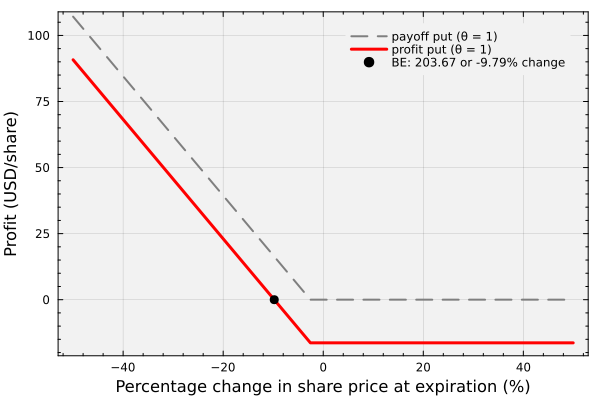

In [36]:
let

    # initialize -
    θ = put_contract_model.sense;
    K = put_contract_model.K;
    premium = put_contract_model.premium;
    number_of_steps = length(payoff_put[:,1]);

    # BEL = zeros(number_of_steps);
    # plot(profit_put[:,1],BEL,lw=3, c=:green, label="Break-even line")
    S = ((payoff_put[:,1] .- Sₒ)./Sₒ) * 100;

    plot(S, payoff_put[:,2],
        lw = 2, 
        c = :gray50,
        ls = :dash,
        label = "payoff put (θ = $(θ))",
        minorticks = 5,
    );

    plot!(S, profit_put[:,2],
        lw = 3, 
        c = :red,
        label = "profit put (θ = $(θ))", 
        ylims = (-premium*1.3, maximum(profit_put[:,2])*1.2),
    );    

    # VLINE = zeros(number_of_steps, 2)
    # VLINE[:,1] .= K*ones(number_of_steps)
    # VLINE[:,2] .= range(minimum(-1*profit_put[:,end]), stop = maximum(profit_put[:,end]), length = number_of_steps) |> collect;
    # plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="K = $(K) USD/share")

    # VLINE = zeros(number_of_steps, 2)
    # VLINE[:,1] .= Sₒ*ones(number_of_steps)
    # VLINE[:,2] .= range(minimum(-1*profit_put[:,end]), stop = maximum(profit_put[:,end]), length = number_of_steps) |> collect;
    # plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :green, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    BE = K - premium;
    breakeven = ((K - premium) - Sₒ) / Sₒ * 100;
    scatter!([breakeven], [0], c=:black, label="BE: $(BE |> x-> round(x, digits=2)) or $(breakeven |> x-> round(x, digits=2))% change", ms=5)
    # scatter!([breakeven], [0], c=:black, label="Breakeven $(breakeven |> x-> round(x, digits=2)) USD/share", ms=5)

    xlabel!("Percentage change in share price at expiration (%)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Analysis of Breakeven Point for a Put Option
The breakeven point for a put option occurs when the profit is zero. This happens when the underlying share price at expiration equals the strike price minus the premium paid for the option. Let's do a quick derivation to show this mathematically. Start with the profit expression for the put option (from the buyer's perspective):
$$
\begin{align*}
P_{p}^{\text{buyer}}(K,S(T)) & = V_{p}(K,S(T)) -  \mathcal{P}_{p}(K,S(0))\quad\text{(buyer's perspective)}\\
0 & = \max(0, K - S(T)) -  \mathcal{P}_{p}(K,S(0))\\
\mathcal{P}_{p}(K,S(0)) & = \max(0, K - S(T))\\
\mathcal{P}_{p}(K,S(0)) & = K - S(T) \quad\text{(since } S(T) < K \text{ at breakeven)}\\
S(T) & = K - \mathcal{P}_{p}(K,S(0)) \quad\text{(breakeven point)}
\end{align*}
$$

The breakeven expression from the perspective of the put option seller is given by:
$$
\begin{align*}
P_{p}^{\text{seller}}(K,S(T)) & = -V_{p}(K,S(T)) +  \mathcal{P}_{p}(K,S(0))\quad\text{(seller's perspective)}\\
0 & = -\max(0, K - S(T)) +  \mathcal{P}_{p}(K,S(0))\\
\mathcal{P}_{p}(K,S(0)) & = \max(0, K - S(T))\\
\mathcal{P}_{p}(K,S(0)) & = K - S(T) \quad\text{(since } S(T) < K \text{ at breakeven)}\\
S(T) & = K - \mathcal{P}_{p}(K,S(0)) \quad\text{(breakeven point)}
\end{align*}
$$

The breakeven point is the same from both perspectives; however, the directional assumptions are the opposite of each other.
___

## Summary
This example demonstrates how to construct individual option contract models and analyze their payoff and profit characteristics across the range of possible share prices at expiration.

> __Key Takeaways:__
>
> * __Payoff versus profit:__ Payoff depends only on the strike price and underlying share price at expiration, while profit adjusts payoff by subtracting the premium paid or adding the premium collected.
> * __Directional asymmetry:__ Call options profit when share prices rise above the breakeven point ($S(T) = K + \mathcal{P}_c$), while put options profit when prices fall below their breakeven point ($S(T) = K - \mathcal{P}_p$).
> * __Breakeven points:__ Single option contracts have exactly one breakeven point that depends on strike price and premium, which can be calculated analytically and verified visually in profit diagrams.

Understanding single option contracts provides the foundation for building composite strategies that combine multiple contracts to express more sophisticated market views.
___

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.